In [1]:
from glob import glob
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#You should print the layers to be able to determine which layers will be used for style and which will be used for content.
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
content = load_image("/content/drive/MyDrive/Colab Notebooks/Style and Content images/dancing.jpg").to(device)
style   = load_image("/content/drive/MyDrive/Colab Notebooks/Style and Content images/picasso.jpg" , shape = content.shape[-2:]).to(device)

In [7]:
print(style.shape)
print(content.shape)

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])


In [8]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

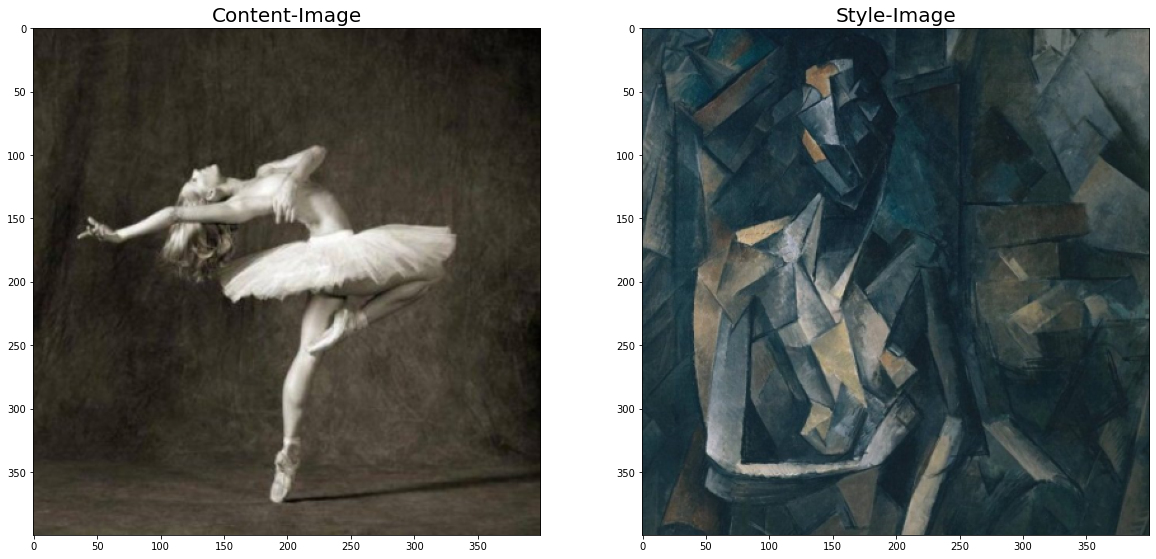

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content-Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style-Image", fontsize = 20)
plt.show()

In [10]:
def get_features(image , model , layers = None):
    if layers is None:
        layers = {'0' : 'conv1_1',
                  '5' : 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', #content
                  '28': 'conv5_1',     
                 }
        
    features = {}
    x = image
    for name , layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [11]:
def gram_matrix(tensor):
    b , d , h , w = tensor.size()
    tensor = tensor.view(b * d , h * w)
    gram = torch.mm(tensor , tensor.t())
    
    return gram

In [12]:
content_features = get_features(content , vgg)
style_features = get_features(style , vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [14]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  213753.125


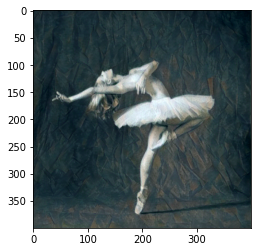

Total loss:  114375.5078125


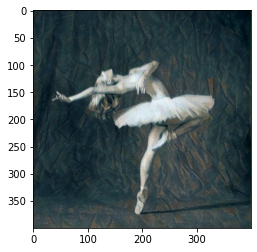

Total loss:  78993.453125


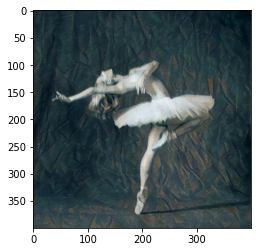

Total loss:  58931.1484375


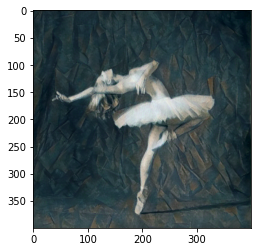

Total loss:  45517.890625


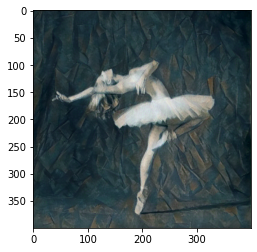

Total loss:  35940.23828125


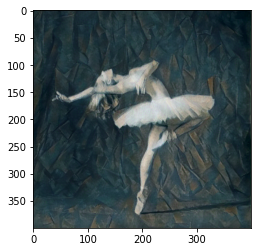

Total loss:  28969.287109375


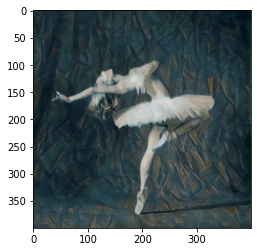

Total loss:  23784.216796875


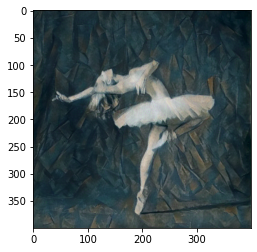

Total loss:  19884.1484375


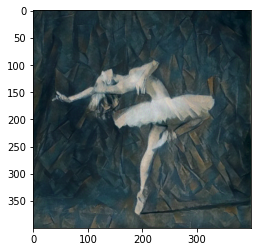

Total loss:  16930.17578125


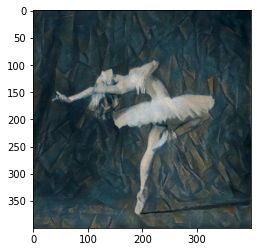

Total loss:  14691.2841796875


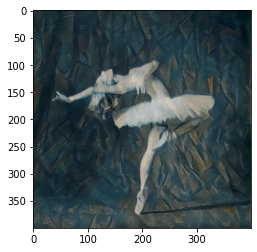

Total loss:  13028.4619140625


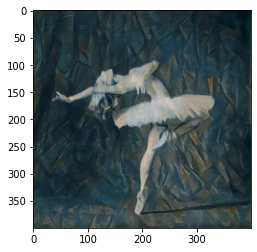

In [15]:
show_every = 400

optimizer = optim.Adam([target] , lr = 0.003)
steps = 5000

for ii in range(1 , steps + 1):
    target_features = get_features(target , vgg)
    content_loss  = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        b , d , h , w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = (style_weight * style_loss) + (content_weight * content_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

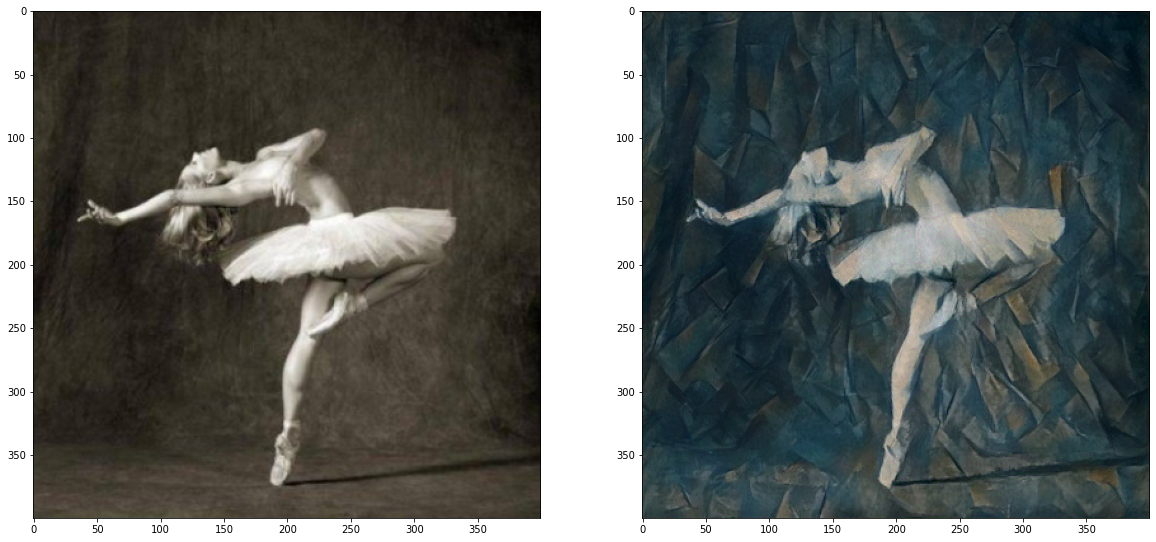

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

**References**

In [17]:
#https://www.pluralsight.com/guides/artistic-neural-style-transfer-with-pytorch
#https://github.com/udacity/deep-learning-v2-pytorch/tree/master/style-transfer
#https://pytorch.org/tutorials/advanced/neural_style_tutorial.html